1. Install Dependences

In [1]:
import os 
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from flask import Flask, request, render_template

In [47]:
# Set the path to your dataset folder
dataset_path = 'data/train'

In [48]:
# Define the categories (subfolders in the dataset folder)
categories = ['benign', 'malignant']

In [49]:
# Define the image dimensions
IMG_SIZE = 224

In [50]:
# Load the dataset
data = []
labels = []

for category in categories:
    folder_path = os.path.join(dataset_path, category)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        data.append(img)
        labels.append(category)

In [51]:
# Convert the data and labels to numpy arrays
data = np.array(data)
labels = np.array(labels)

In [52]:
# Encode the labels to numerical class indices
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

In [53]:
# Convert the labels to categorical
labels = to_categorical(labels)


In [54]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)


In [55]:
# Normalize the pixel values between 0 and 1
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [56]:
# Build the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(categories), activation='softmax'))

In [57]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [58]:
# Data augmentation
datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2,
                             zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')


In [59]:
# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)


In [60]:
# Train the model
history = model.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=20,
                    validation_data=(x_test, y_test), callbacks=[early_stop, checkpoint])


Epoch 1/20
66/66 [==============================] - ETA: 0s - loss: 0.7019 - accuracy: 0.6164
Epoch 1: val_accuracy improved from -inf to 0.66288, saving model to best_model.h5
66/66 [==============================] - 964s 9s/step - loss: 0.7019 - accuracy: 0.6164 - val_loss: 0.5864 - val_accuracy: 0.6629
Epoch 2/20
66/66 [==============================] - ETA: 0s - loss: 0.5436 - accuracy: 0.7160
Epoch 2: val_accuracy improved from 0.66288 to 0.72348, saving model to best_model.h5
66/66 [==============================] - 311s 5s/step - loss: 0.5436 - accuracy: 0.7160 - val_loss: 0.5367 - val_accuracy: 0.7235
Epoch 3/20
66/66 [==============================] - ETA: 0s - loss: 0.4819 - accuracy: 0.7662
Epoch 3: val_accuracy improved from 0.72348 to 0.78409, saving model to best_model.h5
66/66 [==============================] - 344s 5s/step - loss: 0.4819 - accuracy: 0.7662 - val_loss: 0.4524 - val_accuracy: 0.7841
Epoch 4/20
66/66 [==============================] - ETA: 0s - loss: 0.446

In [61]:
# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

17/17 [==============================] - 54s 2s/step - loss: 0.3762 - accuracy: 0.8087
Test accuracy: 0.8087121248245239


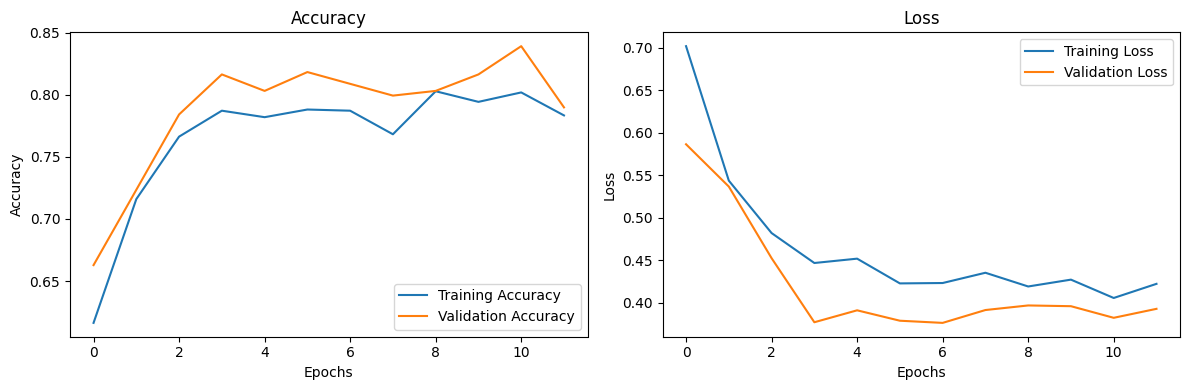

In [62]:
# Plot accuracy and loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [63]:
#Load the best saved model
best_model = load_model('best_model.h5')

In [64]:
#Make predictions on test data
predictions = best_model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)

17/17 [==============================] - 37s 2s/step


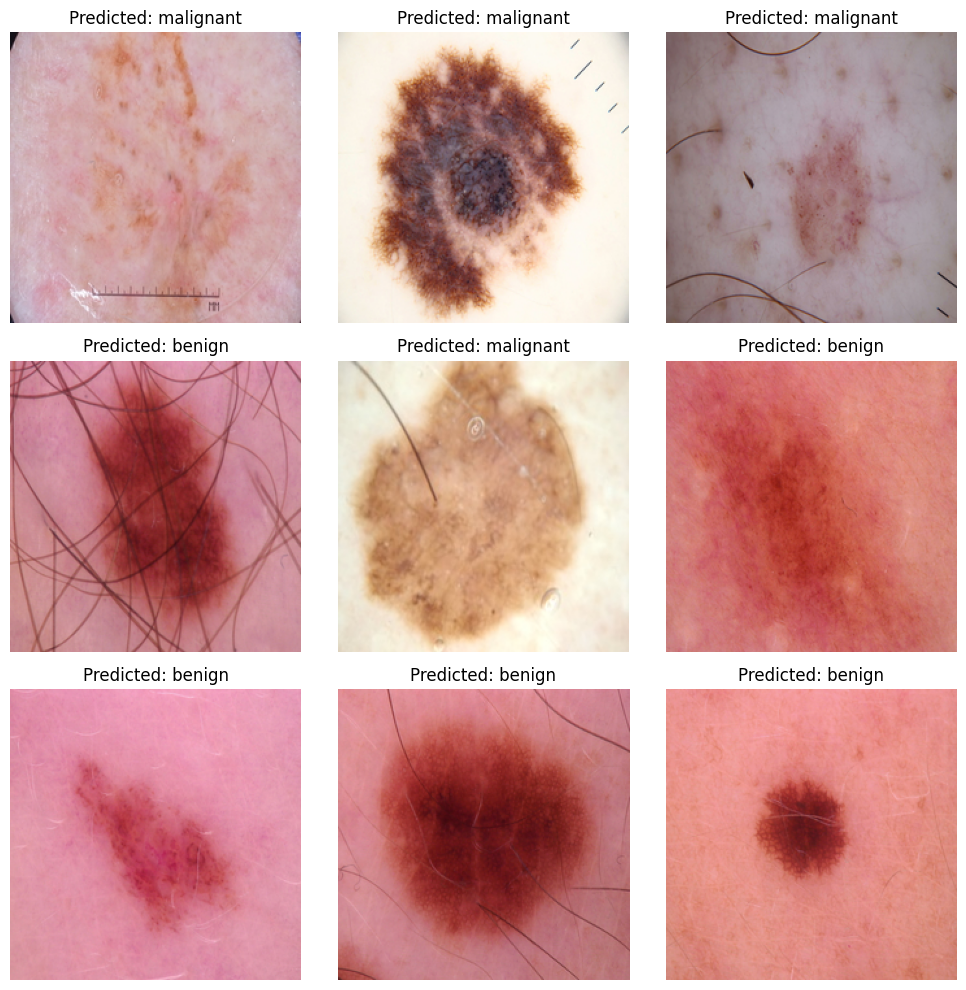

In [65]:
#Display a few sample images with their predicted labels
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.ravel()

for i in range(9):
    axes[i].imshow(x_test[i])
    axes[i].set_title(f"Predicted: {categories[predicted_labels[i]]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [46]:
import numpy as np
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('best_model.h5')

# Dictionary mapping predicted class values to cancer types
cancer_types = {
    0: 'Basal Cell Carcinoma',
    1: 'Squamous Cell Carcinoma',
    2: 'Melanoma',
    3: 'Actinic Keratosis',
    4: 'Merkel Cell Carcinoma',
    5: 'Dermatofibroma',
    6: 'Lipoma'
}

# Prepare your test data (e.g., X_test)
X_test = 
# Make predictions using the trained model
yhat = model.predict(X_test)

# Map the predicted class values to their corresponding cancer types
predicted_cancer_types = [cancer_types[np.argmax(y)] for y in yhat]

# Evaluate the performance of the model (e.g., calculate accuracy, precision, recall, etc.)
# ...

# Print the predicted cancer types for each sample in the test data
for i, predicted_cancer_type in enumerate(predicted_cancer_types):
    print(f'Sample {i + 1}: Predicted cancer type: {predicted_cancer_type}')


NameError: name 'X_test' is not defined

#Test

In [27]:
import cv2
import tensorflow as tf

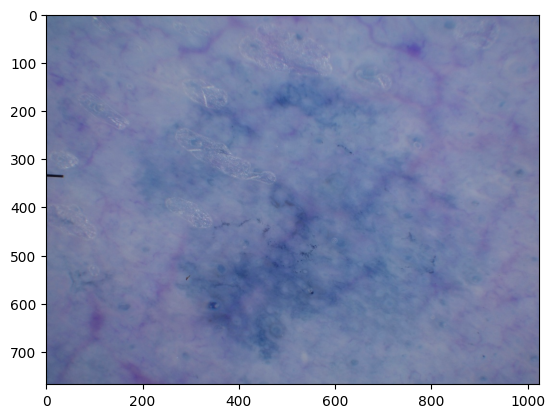

In [41]:
img = cv2.imread('./././././././skin-lesion-analysis-towards-melanoma-detection/Test/actinic-keratosis/0.jpg')
plt.imshow(img)
plt.show()

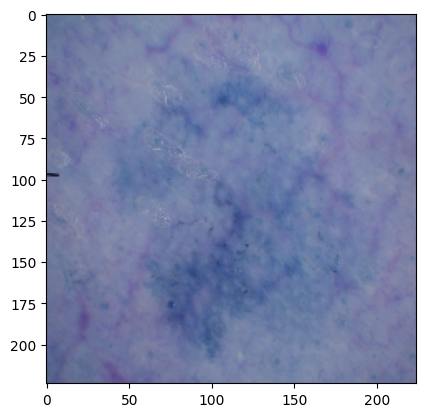

In [42]:
resize = tf.image.resize(img, (224,224))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [43]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 136ms/step


In [44]:
yhat

array([[0.03327233, 0.9321799 , 0.03454774]], dtype=float32)

In [45]:
if np.any(yhat > 1.5):
    print('At least one predicted class is not cancerous')
elif np.any(yhat > 0.5):
    print('At least one predicted class is cancerous')
else:
    print('All predicted classes are less than or equal to 0.5')

At least one predicted class is cancerous


In [21]:
# Initialize Flask application
app = Flask(__name__)

In [22]:
# Define the upload folder
UPLOAD_FOLDER = 'uploads'
app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER

In [23]:
# Function to preprocess the uploaded image
def preprocess_image(image):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)
    return img